<div style="width:100%; text-align:center; margin: 40px 0;">
    <h1 style="color: #003366; font-size: 40px; font-weight:bold; text-shadow: 2px 2px 5px grey;">
        Énergie Électrique en France
    </h1>
    <hr style="width: 50%; height: 3px; background-color: #003366; border: none;">
    <p style="font-style:italic; font-size:18px; color: #555;">
        Une exploration approfondie de l'énergie électrique en France
    </p>
</div>


## Données:

Dans ce projet nous allons travailler sur des données produites par RTE France. Nous allons récolter ces données grâce à une API (OpenData Reseaux Energie https://opendata.reseaux-energies.fr/). Nous allons travailler sur des données régionales récoltées au niveau régional et sur des données nationales. Nous aurons aussi des API qui contiennent des données en temps réel, ce qui nous permettra d'avoir des données mise à jour régulierement.  

Voici les 4 liens API que nous utiliserons durant ce projet:
- Données Nationales en temps réel (du 1er Juin 2022 à aujourd'hui): `https://odre.opendatasoft.com/api/explore/v2.1/catalog/datasets/eco2mix-national-tr`
- Données Nationales fixes (jusqu'au 31 Mai 2022): `https://odre.opendatasoft.com/api/explore/v2.1/catalog/datasets/eco2mix-national-cons-def`
- Données Régionales en temps réel (du 1er Juin 2022 à aujourd'hui): `https://odre.opendatasoft.com/api/explore/v2.1/catalog/datasets/eco2mix-regional-tr`
- Données Régionales fixes (jusqu'au 31 Mai 2022): `https://odre.opendatasoft.com/api/explore/v2.1/catalog/datasets/eco2mix-regional-cons-def`

Grâce au module `request` de python nous allons pouvoir faire des requêtes de type SQL à ces API dans le but d'obtenir les données dont nous avons besoin au format JSON.

Nous utiliserons aussi un fichier GeoJson récupéré sur le site `https://france-geojson.gregoiredavid.fr/`. Ce fichier possède les données géographiques de la France, par région ou par département. Les données de RTE France étant uniquement nationales et régionales, nous utiliserons uniquement le GeoJson des régions de la France.

### Variables que nous allons analyser

- **Date** : *Date à laquelle les données ont ete enregistrees*
- **Heure** : *Date à laquelle les données ont ete enregistrees*
- **Région** (pour les données régionales) : *La région correspondant aux données*
- **Consommation** (MW) : *La consommation électrique réelle*
- **Prévision**  Conso J et J-1 (MW) :  *La consommation électrique prédite par RTE France au jours J et J-1*
- **Production par filières** (MW) : *La production d'energie electrique pqr filiere (nucleaire, hydrolique, eolien, solaire...)*
- **Imports exports  avec plusieurs pays** (MW) : *Echanges d'energie avec les differents pays frontaliers (Suisse, Allemagne, Belgique, Angleterre, Espagne)*
- **Emission de CO2** (g/kWh) : *La valeur d'emission de CO2*

## Type d'analyse prévue

Nous allons effectuer plusieurs visualisations sur nos données afin d'en tirer des observations. Pour cela nous allons principalement utiliser le module `plotly express` qui permet de faire des graphiques interactifs. Nous allons également améliorer l'interactivitée de notre graphique en rajoutant des modules IPython permetant à l'utilisateur de pouvoir trier et filtrer les données.  
Nous effecturons également des analyses statistiques afin de repondre à certains questionnements sur l'électricitée en France.

Pour cela nous concentrerons notre analyse sur 3 axes principaux:
- La consommation électrique en France
- La production d'énergie électrique aux niveaux national et régional
- Les échanges commerciaux avec les pays frontaliers

Nous allons d'abord devoir récupérer, nettoyer et formater les données lors des requêtes à l'API d'OpenData. Nous utiliserons ensuite Python et les bibliothèques Pandas et Plotly pour manipuler ces données et créer des visualisations.

## Résultats attendus

A la fin de cette analyse, nous devrions être capable de répondre à plusieurs questions tel que:
- Quels sont les modes de production les plus importants en France ? Par régions ?
- Comment a évolué la part du renouvelable dans le mix énergétique français durant la dernière décennie ?
- Quel est la balance commerciale de la France pour l’énergie ?
- Comment évolue la production et la consommation de l’électricité  en France  durant 1 journée ? 1 mois ? 1 année ?

Voici le type de graphique que l'on pourrait avoir à la fin de notre analyse:  

Voici un graphique représentant la consommation d'énergie électrique en France sur une seule journée.

![Consommation électrique](IMG/conso.png)

Ensuite nous pourrions avoir un graphique qui montre les échanges d'électricité avec les pays frontaliers.  
  
![Echanges commerciaux](IMG/echanges_comm.png)

Ensuite voici un graphique qui montre la proction d'energie électrique par la filière solaire sur une journée. Nous pouvons voir que le pic de production se situe vers 12h ce qui correspond au moment ou il y a le plus de soleil dans la journée.  
  
![Production d'energie solaire](IMG/production_solaire.png)  

Et pour finir voici un graphique representant la part de production d'énergie électrique pour chaque filiere:  
  
![Production d'energie par filiere](IMG/pie_chart_production.png)  


In [4]:
# Data

URL = "https://odre.opendatasoft.com/api/explore/v2.1/catalog/datasets/"

# Imports
import requests
import json

import pandas as pd

import plotly.express as px


In [5]:
def fetch_data_by_date(data:str, start:int, rows:int, date:str):
    """Fetch data from a dataset by date and offset
    
    Parameters
    ----------
    data : str
        Name of the dataset.
    start : int
        Offset.
    rows : int
        Number of rows.
    date : str
        Date of the data.

    Returns
    -------
    dict
        Dictionary containing the data. 
    """
    url = f"{URL}{data}" + "/records"
    params = {
        "offset" : start,
        "rows": rows,
        "where": f"date='{date}'"
    }
    response = requests.get(url, params=params)
    data=[{}]
    if response.status_code == 200:
        data = response.json()
        return data.get('results', {})
    else:
        print(f"Échec de la requête: {response.status_code}")
        print(response.text)
        return 
    
def get_length_per_date(data:str, date:str):
    """Get the number of rows for a given date

    Parameters
    ----------
    data : str
        Name of the dataset.
    date : str
        Date of the data.

    Returns
    -------
    int
        Number of rows.
    """
    url = f"{URL}{data}" + "/records"
    params = {
        "select": "date",
        "rows": 1,
        "where": f"date='{date}'"
    }
    response = requests.get(url, params=params)
    data=[{}]
    if response.status_code == 200:
        data = response.json()
        return data.get('total_count')
    else:
        print(f"Échec de la requête: {response.status_code}")
        print(response.text)
        return
      

In [6]:
def insert_data_into_json(file_name: str, new_data: list):
    """Insère de nouvelles données dans un fichier JSON existant.

    Parameters
    ----------
    file_name : str
        Le nom du fichier JSON.
    new_data : list
        La liste des nouvelles données à insérer.
    """
    try:
        with open(file_name, 'r') as file:
            existing_data = json.load(file)
    except FileNotFoundError:
        existing_data = []

    existing_data.extend(new_data)

    with open(file_name, 'w') as file:
        json.dump(existing_data, file)

for i in range(1, 31):
    date = f"2023-11-{i:02}"
    length = get_length_per_date('eco2mix-national-tr', date)
    print(f"{date} : {length}")
    new_data = fetch_data_by_date('eco2mix-national-tr', 0, length, date)
    insert_data_into_json('combined_data.json', new_data)

2023-11-01 : 96
2023-11-02 : 96
2023-11-03 : 96
2023-11-04 : 96
2023-11-05 : 96
2023-11-06 : 96
2023-11-07 : 96
2023-11-08 : 96
2023-11-09 : 96
2023-11-10 : 96
2023-11-11 : 96
2023-11-12 : 96
2023-11-13 : 96
2023-11-14 : 96
2023-11-15 : 96
2023-11-16 : 96
2023-11-17 : 96
2023-11-18 : 96
2023-11-19 : 96
2023-11-20 : 96
2023-11-21 : 96
2023-11-22 : 96
2023-11-23 : 96
2023-11-24 : 96
2023-11-25 : 96
2023-11-26 : 96
2023-11-27 : 96
2023-11-28 : 96
2023-11-29 : 96
2023-11-30 : 96


In [7]:
def transform_json_to_df(file_name:str):
    """Transform a Json File to a pandas DataFrame"""
    with open(file_name) as f:
        data = json.load(f)
    return pd.DataFrame(data)
    
df = transform_json_to_df('combined_data.json')
df

,perimetre,nature,date,heure,date_heure,consommation,prevision_j1,prevision_j,fioul,charbon,...,gaz_ccg,gaz_autres,hydraulique_fil_eau_eclusee,hydraulique_lacs,hydraulique_step_turbinage,bioenergies_dechets,bioenergies_biomasse,bioenergies_biogaz,stockage_batterie,destockage_batterie
0,France,Données temps réel,2023-11-01,00:00,2023-10-31T23:00:00+00:00,45304,45200,45500,223,6,...,887,0,5283,1659,872,73,356,245,-7,2
1,France,Données temps réel,2023-11-01,01:00,2023-11-01T00:00:00+00:00,40996,41000,41300,225,6,...,562,0,5239,1805,592,71,358,245,-11,4
2,France,Données temps réel,2023-11-01,04:30,2023-11-01T03:30:00+00:00,36058,35700,36200,230,6,...,215,0,4791,1401,27,89,355,245,-2,1
3,France,Données temps réel,2023-11-01,07:00,2023-11-01T06:00:00+00:00,38643,38700,38900,227,6,...,209,0,4790,1353,132,81,355,245,-1,0
4,France,Données temps réel,2023-11-01,07:30,2023-11-01T06:30:00+00:00,38925,38900,39000,224,6,...,148,0,4769,1705,327,82,355,245,-12,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,France,Données temps réel,2023-11-30,12:00,2023-11-30T11:00:00+00:00,67609,68300,68000,186,587,...,5725,0,6313,4032,2960,71,506,246,-2,11
2876,France,Données temps réel,2023-11-30,14:15,2023-11-30T13:15:00+00:00,65158,65050,65200,187,350,...,5510,0,6325,3258,1986,74,507,246,-12,2
2877,France,Données temps réel,2023-11-30,16:45,2023-11-30T15:45:00+00:00,63335,64600,63650,397,541,...,5493,0,6115,3848,2710,76,510,246,-3,1
2878,France,Données temps réel,2023-11-30,17:00,2023-11-30T16:00:00+00:00,64063,65100,64000,315,596,...,5205,0,6186,3773,2512,75,512,246,-6,0


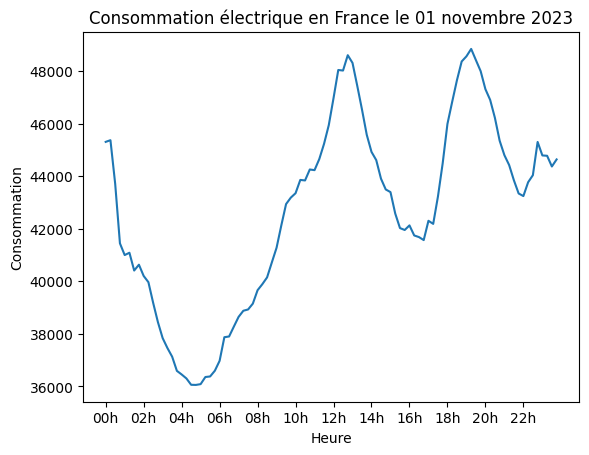

In [55]:
import matplotlib.pyplot as plt
from ipywidgets import interact_manual

@interact_manual(day=(1,30))
def line_chart_consumption_november(day: int = 1) -> None:
    """Generate an interactive line chart of electricity consumption in France for a specific day in November 2023.

    Parameters
    ----------
    day : int
        Day of November 2023.
    
    Returns
    -------
    None

    """
    df = transform_json_to_df('combined_data.json')
    df = df[df['date'] == f'2023-11-{day:02}']
    df = df.sort_values(by=['heure'])
    
    plt.figure()
    plt.plot(df['heure'], df['consommation'])
    plt.xticks([f'{str(i).zfill(2)}:00' for i in range(0,24,2)], [f'{str(i).zfill(2)}h' for i in range(0,24,2)])
    plt.xlabel('Heure')
    plt.ylabel('Consommation')
    plt.title(f'Consommation électrique en France le {day:02} novembre 2023')